# Lab 2: Clustering

The goal of this lab session is to code a clustering algorithm, apply it to data and compare the performance with other techniques.

You have to send the filled notebook named **"L2_familyname1_familyname2.ipynb"** (groups of 2) by email to aml.centralesupelec.2019@gmail.com by October 9, 2019. Please put **"AML-L2"** in the subject. 

We begin with the standard imports:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.cluster as cluster # all clustering techniques except hdbscan
%matplotlib inline
sns.set_context('poster')
sns.set_color_codes()
plot_kwds = {'alpha' : 0.25, 's' : 80, 'linewidths':0}

We will have two toy datasets to try the different methods:

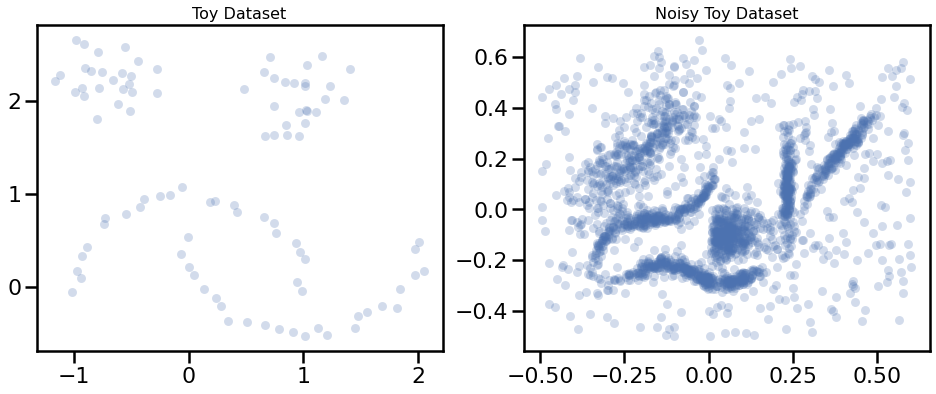

In [6]:
import sklearn.datasets as data
moons, _ = data.make_moons(n_samples=50, noise=0.05)
blobs, _ = data.make_blobs(n_samples=50, centers=[(-0.75,2.25), (1.0, 2.0)], cluster_std=0.25)
test_data_0 = np.vstack([moons, blobs])

test_data_1 = np.load('clusterable_data.npy')

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
ax[0].scatter(test_data_0.T[0], test_data_0.T[1], c='b', **plot_kwds)
ax[0].set_title('Toy Dataset', size=16)

ax[1].scatter(test_data_1.T[0], test_data_1.T[1], color='b', **plot_kwds)
ax[1].set_title('Noisy Toy Dataset', size=16)

plt.show();

There are a lot of clustering algorithms to choose from the `sklearn` library. So what clustering algorithms should you be using? It depends.

## K-means

K-Means is the 'go-to' clustering algorithm for many simply because it is fast, easy to understand, and available everywhere (there's an implementation in almost any statistical or machine learning tool you care to use). However, K-Means has a few problems caused by its simplicity. 

We try the `sklearn` implementation in our toy datasets:

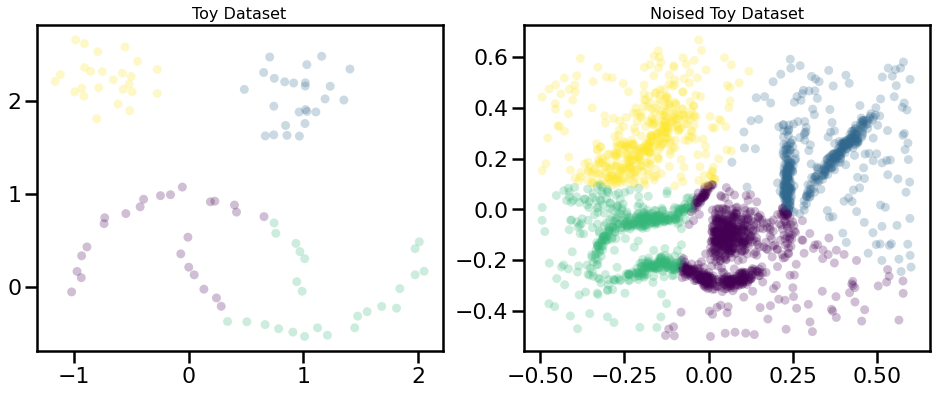

In [7]:
from sklearn.cluster import KMeans
kmeans_0 = KMeans(n_clusters=4, max_iter=200).fit(test_data_0)
kmeans_1 = KMeans(n_clusters=4, max_iter=200).fit(test_data_1)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
ax[0].scatter(test_data_0.T[0], test_data_0.T[1], c=kmeans_0.labels_ , **plot_kwds)
ax[0].set_title('Toy Dataset', size=16)

ax[1].scatter(test_data_1.T[0], test_data_1.T[1], c=kmeans_1.labels_, **plot_kwds)
ax[1].set_title('Noised Toy Dataset', size=16)


plt.show();

## Aglomerative Single Linkage clustering

Agglomerative clustering is a suite of algorithms all based on the same idea. The fundamental idea is that you start with each point in it's own cluster and then, for each cluster, use some criterion to choose another cluster to merge with. Do this repeatedly until you have only one cluster and you get get a hierarchy, or binary tree, of clusters branching down to the last layer which has a leaf for each point in the dataset. The most basic version of this, single linkage, chooses the closest cluster to merge, and hence the tree can be ranked by distance as to when clusters merged/split.

**Code your own Aglomerative Single Linkage clustering algorithm**!:

- Fill in the class 
- During the process, keep track of the cluster merges by saving a (num_samples-1,4) np.array being a linkage matrix in scypy format (to use their function to plot dendrogram: `scipy.cluster.hierarchy.dendrogram`). check documentation.

In [30]:
from scipy.spatial import distance 
from scipy.cluster.hierarchy import dendrogram

class my_SingleLinkageAglomerativeClustering():
    
    def __init__(self, metric="euclidean", n_clusters=3):
        '''
        Attributes:
        
        metric_: {"euclidean","precomputed"}
            the distance to be used
            if precomputed then X is distance matrix
        n_clusters: integer
            number of clusters to return 
        linkage_matrix_: (n-1, 4) np.array
            in the same format as linkage  
        labels_: integer np.array
            label assigment
        hierarchy_: list of np.array
            each array corresponds to label assigment
            at each level (number of clusters)
            hierarchy_[0]=np.array(list(range(n)))
        '''
        self.metric_ = metric
        self.n_clusters_ = n_clusters
        self.linkage_matrix_ = None
        self.labels_ = None
        self.hierarchy_ = None
        
    def fit(self, X):
        """ Create a hierarchy of clusters
        
        Parameters:
        -----------
        X: (n, p) np.array
            Data matrix
        
        Returns:
        -----
        self: my_SingleLinkageAglomerativeClustering
            to have access to labels_
        """
        # if it's not precomputed compute the distance matrix
        # using from scipy.spatial import distance 
        
        # HINT:
        # You can use a minimum spanning tree and add merge in increasing order
        # or modifying the distance matrix 
        # (add row/column for new clusters and remove/put zero in old row/colums)
        
        # keep track of merges in linkage_matrix_ and labels in hierarchy_
        
        # update labels_ from the hierarchy level selected by n_clusters_ 
        
        if self.metric_ == "euclidean":
            distance_matrix = distance.cdist(X, X)
        elif self.metric_ == "precomputed":
            distance_matrix = X.copy()
        else :
            raise ValueError('The specified metric is unknown.')
        
        n = X.shape[0]
        
        self.hierarchy_ = np.array([list(range(n))])
        self.linkage_matrix_ = np.empty((0, 4), dtype=float)
        
        iteration = 0
        infinity_ = 10000000
        

        def get_min(A, infinity=infinity_):
            for j in range(A.shape[0]):
                for i in range(j, A.shape[0]):
                    A[i][j] = infinity_
            return A.min(), np.unravel_index(A.argmin(), A.shape)

        while iteration < n-1:
            # Get the clusters with the minimum distance
            min_distance, to_be_merged = get_min(distance_matrix.copy(), infinity_)
            previous_labels = self.hierarchy_[-1].copy()
            
            # Update the linkage matrix
            nb_obs_new_clust = (previous_labels == to_be_merged[0]).sum() + (previous_labels == to_be_merged[1]).sum()
            self.linkage_matrix_ = np.append(self.linkage_matrix_, np.array([[to_be_merged[0], to_be_merged[1], 
                                                                              min_distance, nb_obs_new_clust]]), axis=0)
            
            # Update the labels after the merging of clusters
            previous_labels[(previous_labels==to_be_merged[0]) | (previous_labels==to_be_merged[1])] = n + iteration

            self.hierarchy_ = np.append(self.hierarchy_, np.array([previous_labels]), axis=0)
            
            # Add new column/row for the new cluster in the distance matrix
            distances_to_new_cluster = np.minimum(distance_matrix[to_be_merged[0]], distance_matrix[to_be_merged[1]])
            distance_matrix = np.append(distance_matrix, distances_to_new_cluster.reshape((-1,1)), axis=1)
            distance_matrix = np.append(distance_matrix, np.array([np.append(distances_to_new_cluster, infinity_)]), axis=0)
            
            # Delete information of the old merged clusters
            distance_matrix[:, to_be_merged[0]] = infinity_
            distance_matrix[:, to_be_merged[1]] = infinity_
            distance_matrix[to_be_merged[0], :] = infinity_
            distance_matrix[to_be_merged[1], :] = infinity_
            iteration += 1
        
        self.labels_ = self.hierarchy_[-self.n_clusters_]
        
    def plot_dendrogram(self):
        '''Use self.linkage_matrix_ in `scipy.cluster.hierarchy.dendrogram` 
        to plot the dendrogram of the hierarchical structure
        '''
        dendrogram(self.linkage_matrix_)

Apply the method to our toy datasets

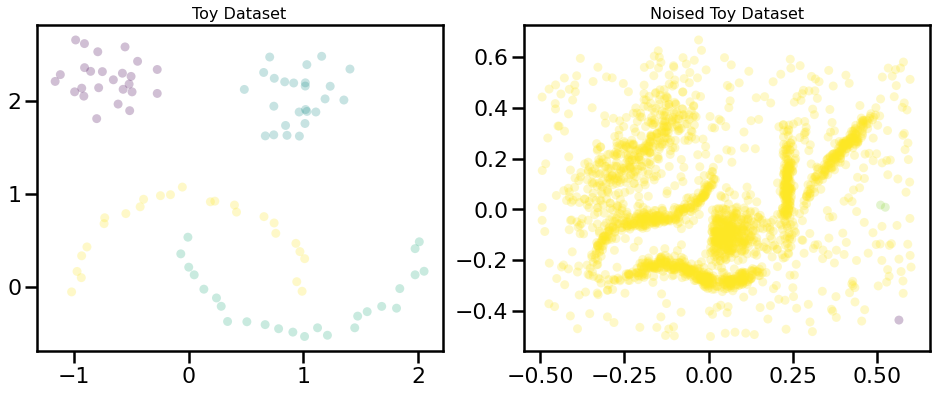

In [39]:
SLAC_0 = my_SingleLinkageAglomerativeClustering(metric='euclidean', n_clusters=4)
SLAC_0.fit(test_data_0)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
ax[0].scatter(test_data_0.T[0], test_data_0.T[1], c=SLAC_0.labels_ , **plot_kwds)
ax[0].set_title('Toy Dataset', size=16)

SLAC_1 = my_SingleLinkageAglomerativeClustering(metric='euclidean', n_clusters=4)
SLAC_1.fit(test_data_1)

ax[1].scatter(test_data_1.T[0], test_data_1.T[1], c=SLAC_1.labels_, **plot_kwds)
ax[1].set_title('Noised Toy Dataset', size=16)

plt.show();

{'icoord': [[5.0, 5.0, 15.0, 15.0],
  [45.0, 45.0, 55.0, 55.0],
  [35.0, 35.0, 50.0, 50.0],
  [75.0, 75.0, 85.0, 85.0],
  [65.0, 65.0, 80.0, 80.0],
  [115.0, 115.0, 125.0, 125.0],
  [135.0, 135.0, 145.0, 145.0],
  [155.0, 155.0, 165.0, 165.0],
  [140.0, 140.0, 160.0, 160.0],
  [120.0, 120.0, 150.0, 150.0],
  [105.0, 105.0, 135.0, 135.0],
  [95.0, 95.0, 120.0, 120.0],
  [72.5, 72.5, 107.5, 107.5],
  [42.5, 42.5, 90.0, 90.0],
  [25.0, 25.0, 66.25, 66.25],
  [185.0, 185.0, 195.0, 195.0],
  [175.0, 175.0, 190.0, 190.0],
  [205.0, 205.0, 215.0, 215.0],
  [182.5, 182.5, 210.0, 210.0],
  [235.0, 235.0, 245.0, 245.0],
  [225.0, 225.0, 240.0, 240.0],
  [196.25, 196.25, 232.5, 232.5],
  [45.625, 45.625, 214.375, 214.375],
  [10.0, 10.0, 130.0, 130.0],
  [265.0, 265.0, 275.0, 275.0],
  [285.0, 285.0, 295.0, 295.0],
  [270.0, 270.0, 290.0, 290.0],
  [255.0, 255.0, 280.0, 280.0],
  [305.0, 305.0, 315.0, 315.0],
  [335.0, 335.0, 345.0, 345.0],
  [325.0, 325.0, 340.0, 340.0],
  [365.0, 365.0, 375.0, 

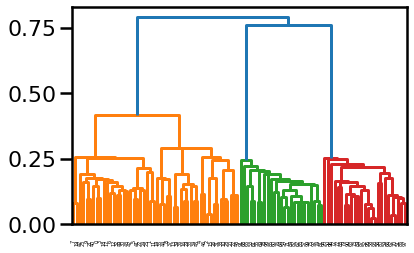

In [61]:
SLAC_0.plot_dendrogram()

Try the different linkage methods implemented in `sklearn`  and comment

#### Single Linkage

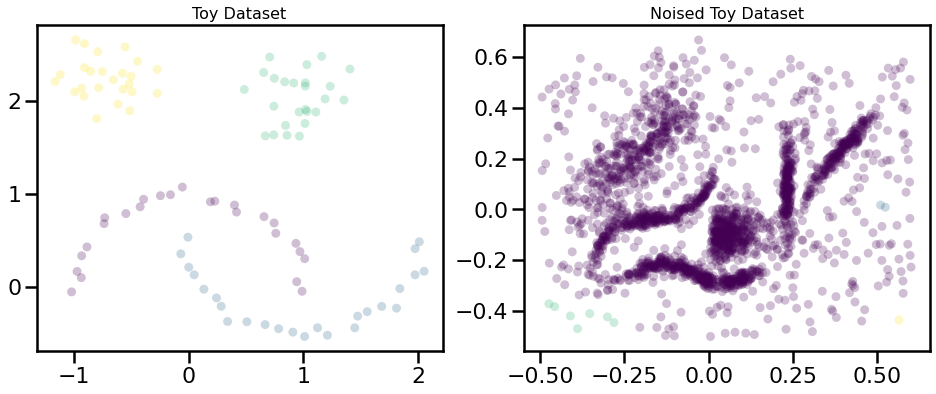

In [33]:
from sklearn.cluster import AgglomerativeClustering

SLAC_00 = AgglomerativeClustering(affinity='euclidean', n_clusters=4, linkage="single").fit(test_data_0)
SLAC_11 = AgglomerativeClustering(affinity='euclidean', n_clusters=4, linkage="single").fit(test_data_1)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
ax[0].scatter(test_data_0.T[0], test_data_0.T[1], c=SLAC_00.labels_ , **plot_kwds)
ax[0].set_title('Toy Dataset', size=16)

ax[1].scatter(test_data_1.T[0], test_data_1.T[1], c=SLAC_11.labels_, **plot_kwds)
ax[1].set_title('Noised Toy Dataset', size=16)


plt.show();

#### Complete Linkage

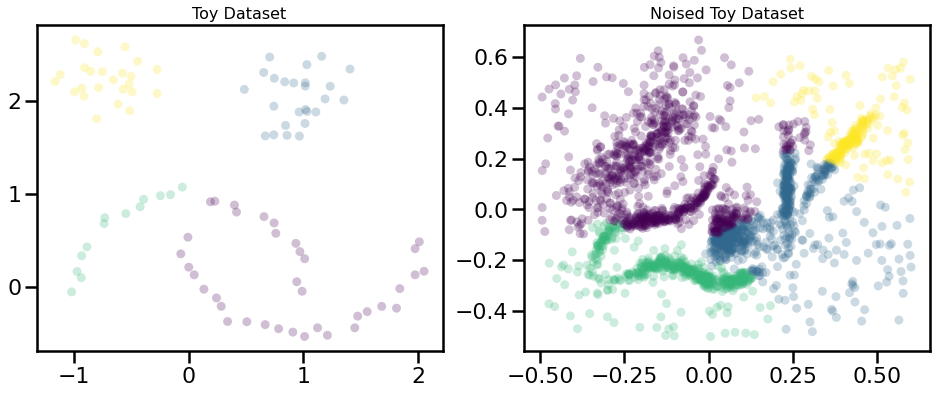

In [34]:
CLAC_0 = AgglomerativeClustering(affinity='euclidean', n_clusters=4, linkage="complete").fit(test_data_0)
CLAC_1 = AgglomerativeClustering(affinity='euclidean', n_clusters=4, linkage="complete").fit(test_data_1)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
ax[0].scatter(test_data_0.T[0], test_data_0.T[1], c=CLAC_0.labels_ , **plot_kwds)
ax[0].set_title('Toy Dataset', size=16)

ax[1].scatter(test_data_1.T[0], test_data_1.T[1], c=CLAC_1.labels_, **plot_kwds)
ax[1].set_title('Noised Toy Dataset', size=16)


plt.show();

#### Ward Linkage

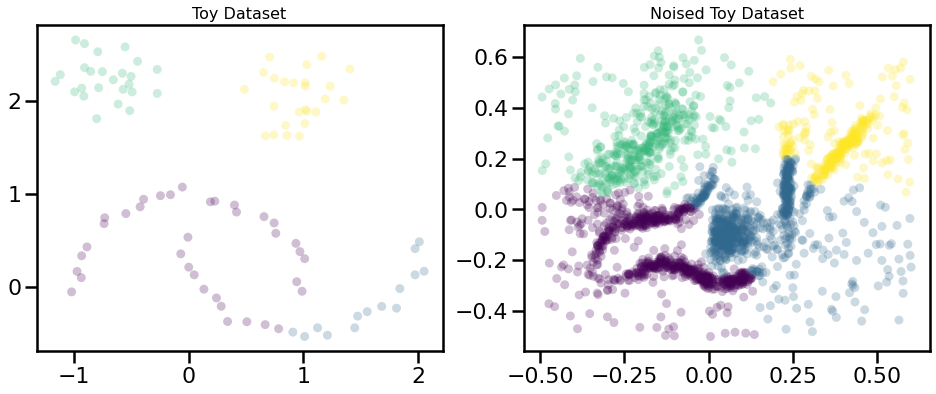

In [35]:
WLAC_0 = AgglomerativeClustering(affinity='euclidean', n_clusters=4, linkage="ward").fit(test_data_0)
WLAC_1 = AgglomerativeClustering(affinity='euclidean', n_clusters=4, linkage="ward").fit(test_data_1)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
ax[0].scatter(test_data_0.T[0], test_data_0.T[1], c=WLAC_0.labels_ , **plot_kwds)
ax[0].set_title('Toy Dataset', size=16)

ax[1].scatter(test_data_1.T[0], test_data_1.T[1], c=WLAC_1.labels_, **plot_kwds)
ax[1].set_title('Noised Toy Dataset', size=16)


plt.show();

#### Average Linkage

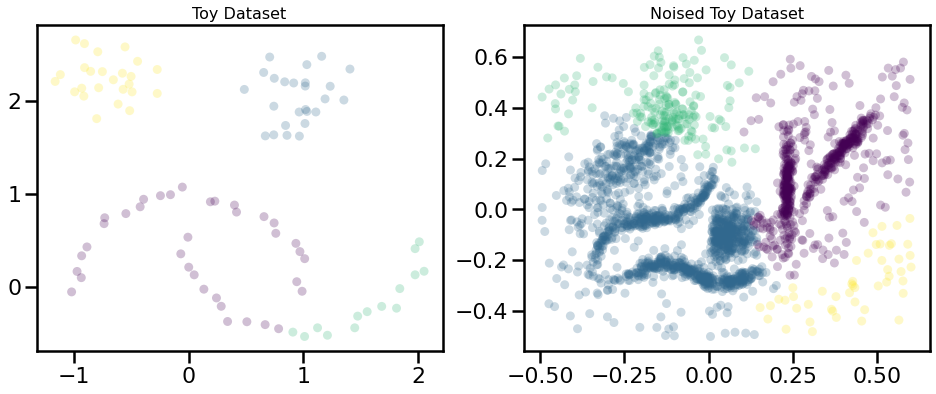

In [37]:
ALAC_0 = AgglomerativeClustering(affinity='euclidean', n_clusters=4, linkage="average").fit(test_data_0)
ALAC_1 = AgglomerativeClustering(affinity='euclidean', n_clusters=4, linkage="average").fit(test_data_1)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
ax[0].scatter(test_data_0.T[0], test_data_0.T[1], c=ALAC_0.labels_ , **plot_kwds)
ax[0].set_title('Toy Dataset', size=16)

ax[1].scatter(test_data_1.T[0], test_data_1.T[1], c=ALAC_1.labels_, **plot_kwds)
ax[1].set_title('Noised Toy Dataset', size=16)


plt.show();

## DBSCAN

DBSCAN is a density based algorithm -- it assumes clusters for dense regions. It is also the first actual clustering algorithm we've looked at: it doesn't require that every point be assigned to a cluster and hence doesn't partition the data, but instead extracts the 'dense' clusters and leaves sparse background classified as 'noise'. In practice DBSCAN is related to agglomerative clustering. As a first step DBSCAN transforms the space according to the density of the data: points in dense regions are left alone, while points in sparse regions are moved further away. Applying single linkage clustering to the transformed space results in a dendrogram, which we cut according to a distance parameter (called epsilon or `eps` in many implementations) to get clusters. Importantly any singleton clusters at that cut level are deemed to be 'noise' and left unclustered. 

Apply it to the test_data, how do you tune the parameters?

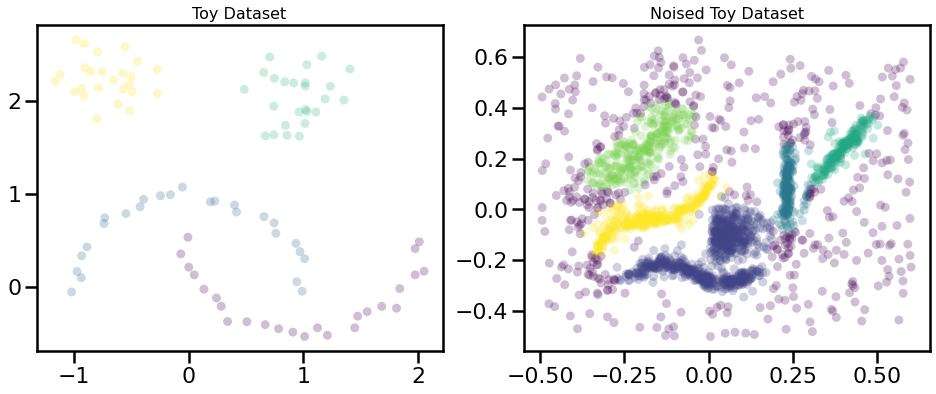

In [38]:
from sklearn.cluster import DBSCAN

dbscan_0 = DBSCAN(eps=0.4, min_samples=5, metric='euclidean').fit(test_data_0)
dbscan_1 = DBSCAN(eps=0.05, min_samples=40, metric='euclidean').fit(test_data_1)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
ax[0].scatter(test_data_0.T[0], test_data_0.T[1], c=dbscan_0.labels_ , **plot_kwds)
ax[0].set_title('Toy Dataset', size=16)

ax[1].scatter(test_data_1.T[0], test_data_1.T[1], c=dbscan_1.labels_, **plot_kwds)
ax[1].set_title('Noised Toy Dataset', size=16)


plt.show();

#### MinPts increases when the number of total observations increases

#### To choose epsilon, we take a number of neighbors k and we compute the average distance to the k nearest neighbors for our observations. Then we plot this average distance versus k and when there's an elbow, we take the corresponding average distance as an approximate value for a good epsilon.

## HDBSCAN

HDBSCAN is a recent algorithm developed by some of the same people who write the original DBSCAN paper. Their goal was to allow varying density clusters. The algorithm starts off much the same as DBSCAN: we transform the space according to density, exactly as DBSCAN does, and perform single linkage clustering on the transformed space. Instead of taking an epsilon value as a cut level for the dendrogram however, a different approach is taken: the dendrogram is condensed by viewing splits that result in a small number of points splitting off as points 'falling out of a cluster'. This results in a smaller tree with fewer clusters that 'lose points'. That tree can then be used to select the most stable or persistent clusters. This process allows the tree to be cut at varying height, picking our varying density clusters based on cluster stability.

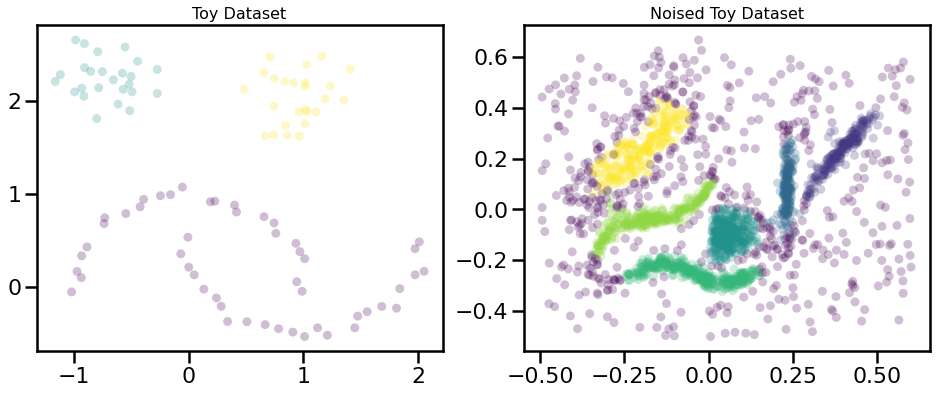

In [41]:
import hdbscan

hdbscan_0 = hdbscan.HDBSCAN(min_cluster_size=5)
hdbscan_1 = hdbscan.HDBSCAN(min_cluster_size=20)


fig, ax = plt.subplots(1, 2, figsize=(16, 6))
ax[0].scatter(test_data_0.T[0], test_data_0.T[1], c=hdbscan_0.fit_predict(test_data_0) , **plot_kwds)
ax[0].set_title('Toy Dataset', size=16)

ax[1].scatter(test_data_1.T[0], test_data_1.T[1], c=hdbscan_1.fit_predict(test_data_1), **plot_kwds)
ax[1].set_title('Noised Toy Dataset', size=16)


plt.show();

## Apply the algorithms to the following images and comment the results

### NASA Curiosity Picture

- Look at following NASA photo taken by a robot in mars:


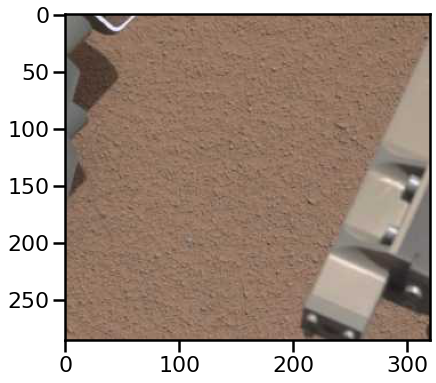

In [42]:
from PIL import Image

Im_1  = Image.open('im_nasa_reduced.jpg')

fig = plt.figure(figsize=(8, 6))
plt.imshow(Im_1)
plt.show()

- Transform the image to an intensity (I) and saturation (S) representation, it helps to distinguish bright and textures.

$$I=\frac{R+G+B}{3}$$
$$S=1-I\times min(R, G, B)$$

In [43]:
rgb_values = np.array(Im_1.getdata()) / 255

I = rgb_values.mean(axis=1)
S = 1 - I * rgb_values.min(axis=1)

X = np.append(I.reshape(-1,1), S.reshape(-1,1) , axis=1)

- Apply the seen algorithms to segment the image in the Intensity-Saturation representation, comment the results and check if you find something on mars' surface. Be careful with hdbscan and memory errors for some parameters choice (use algorithm='boruvka_kdtree').

##### Cluster with kMeans

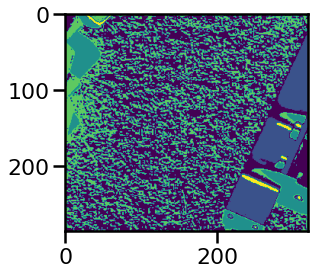

In [49]:
from sklearn.cluster import KMeans

clusterer = KMeans(n_clusters=5, max_iter=200).fit(X)
labels_im = clusterer.labels_.reshape(Im_1.size[1], Im_1.size[0])
plt.imshow(labels_im)

##### Cluster with Single Linkage Agglomerative Clustering

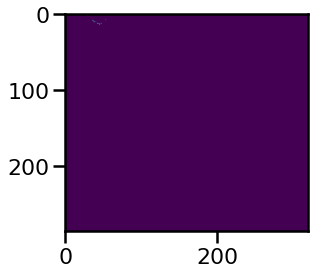

In [55]:
from sklearn.cluster import AgglomerativeClustering

clusterer = AgglomerativeClustering(affinity='euclidean', n_clusters=5, linkage="single").fit(X)
labels_im = clusterer.labels_.reshape(Im_1.size[1], Im_1.size[0])
plt.imshow(labels_im)

##### Cluster with DBSCAN

In [57]:
from sklearn.cluster import DBSCAN

clusterer = DBSCAN(eps=0.2, min_samples=100, metric='euclidean').fit(X)
labels_im = clusterer.labels_.reshape(Im_1.size[1], Im_1.size[0])
plt.imshow(labels_im)

MemoryError: 

In [ ]:
## I keep getting memory errors for DBSCAN and HDBSCAN

### Color compression

One interesting application of clustering is in color compression within images. 
For example, imagine you have an image with millions of colors.
In most images, a large number of the colors will be unused, and many of the pixels in the image will have similar or even identical colors.

Get a simplified 10-colored version of the following image by applying k-means. Plot both images.

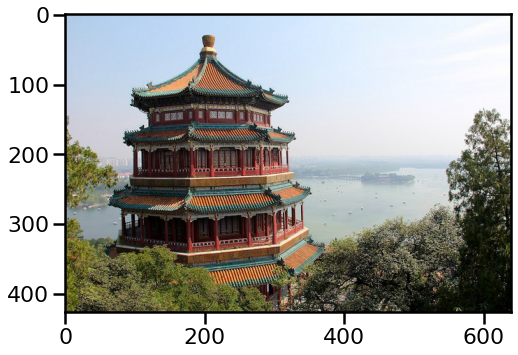

In [58]:
from sklearn.datasets import load_sample_image
china = load_sample_image("china.jpg")

fig = plt.figure(figsize=(8, 6))
plt.imshow(china);

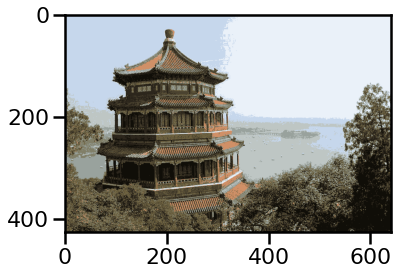

In [59]:
# Do kmeans clustering with k=10

from sklearn.cluster import KMeans

china_flat = china.reshape(china.shape[0]*china.shape[1],3)

clusterer = KMeans(n_clusters=10, max_iter=200).fit(china_flat)

# Affect the clusters centers to the nearest points

china_compressed = np.zeros((china.shape[0]*china.shape[1], 3), dtype='uint8')
centers = clusterer.cluster_centers_.astype(int)
for i in range(10):
    china_compressed[clusterer.labels_==i] = centers[i]

    
# Reshape and plot    
china_compressed = china_compressed.reshape(china.shape[0], china.shape[1], 3)
plt.imshow(china_compressed)